# Import the data


In [36]:
import scipy.io as sio
import mat73
flow2 = mat73.loadmat('../data/doppler/flow2.mat')
flow2 = flow2['IQA']
rat_brain = sio.loadmat('../data/doppler/rat_brain.mat')
rat_brain = rat_brain['IQA']

In [37]:
# print shapes
print(flow2.shape)
print(rat_brain.shape)

(120, 128, 150)
(156, 128, 200)


In [38]:
import matplotlib.pyplot as plt
import numpy as np

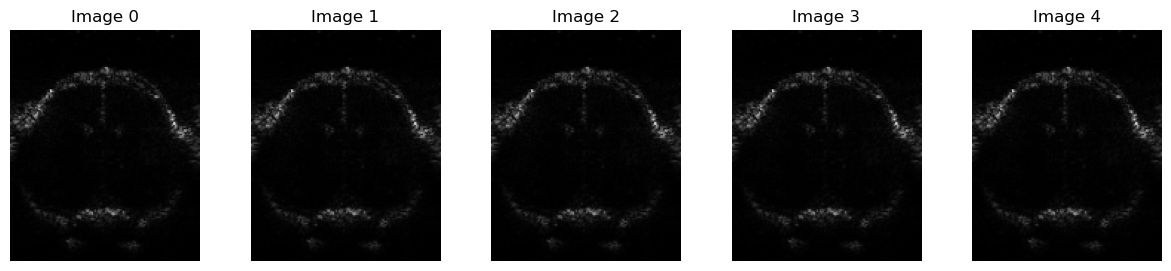

In [39]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.abs(rat_brain[:,:,i]), cmap='gray')
    if phase :
        ax[i].imshow(np.angle(rat_brain[:,:,i]), alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

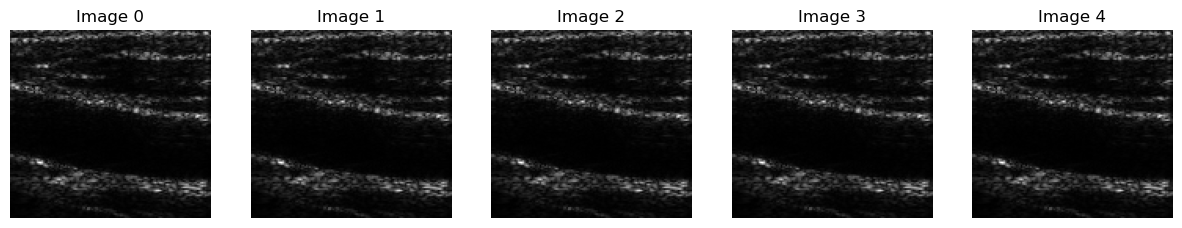

In [40]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.abs(flow2[:, :,i]), cmap="gray")
    if (phase):
        ax[i].imshow(np.angle(flow2[:,:,i]), alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

In [41]:
import numpy as np
def casorati_matrix(data):
    # Takes a 3D matrix of dimension (n_x, n_z, n_t) and returns a 2D matrix of dimension (n_x*n_z, n_t)
    n_x, n_z, n_t = data.shape
    data = np.reshape(data, (n_x*n_z, n_t))
    return data

def casorati_matrix_inverse(data, n_x, n_z):
    # Takes a 2D matrix of dimension (n_x*n_z, n_t) and returns a 3D matrix of dimension (n_x, n_z, n_t)
    n_t = data.shape[1]
    data = np.reshape(data, (n_x, n_z, n_t))
    return data

In [42]:
# ## Test casorati_matrix
# # Generate a 3D matrix of dimension (n_x, n_z, n_t)
# n_x , n_z, n_t = 4, 2, 3
# data = np.random.rand(n_x, n_z, n_t)
# print("-------3D matrix")
# print(data)
# print(data.shape)
# # Convert to 2D matrix
# data_casorati = casorati_matrix(data)
# print("-------2D matrix")
# print(data)
# print(data.shape)
# # Convert back to 3D matrix
# data_casorati_inverse = casorati_matrix_inverse(data_casorati, n_x, n_z)
# print("-------3D matrix")
# print(data_casorati_inverse)
# print(data_casorati_inverse.shape)
# print("Successful reconstruction :", np.allclose(data, data_casorati_inverse))

In [43]:
# Apply casorati_matrix to flow2 and rat_brain
flow2_casorati = casorati_matrix(flow2)
rat_brain_casorati = casorati_matrix(rat_brain)

(19968, 200)

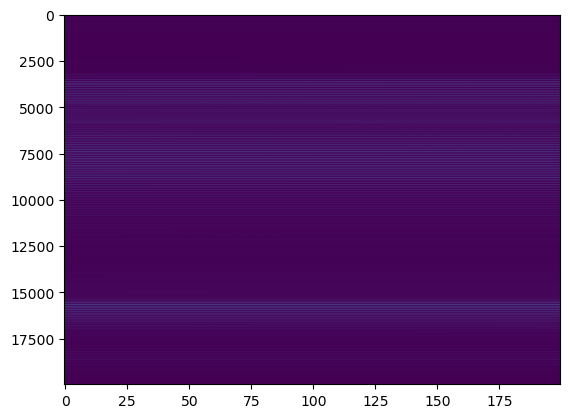

In [44]:
plt.imshow(np.abs(rat_brain_casorati), aspect="auto")
rat_brain_casorati.shape

In [45]:
# compute covarance matrix
cov_rat_brain = np.absolute( rat_brain_casorati.conj().T @ rat_brain_casorati )
cov_flow2 = np.absolute( np.matmul(flow2_casorati.conj().T,flow2_casorati) )
print(cov_rat_brain.shape)
print(cov_flow2.shape)

(200, 200)
(150, 150)


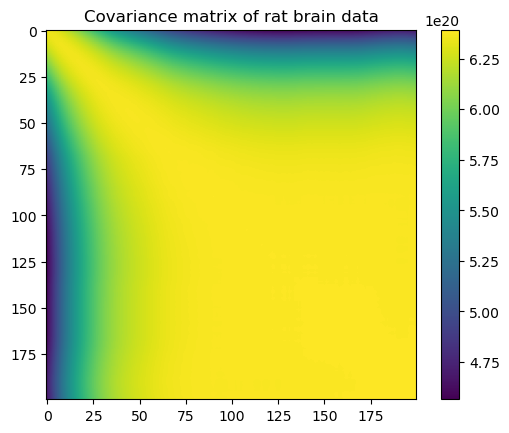

In [46]:
# Plot covariance matrix of rat brain data
plt.imshow(cov_rat_brain)
plt.title("Covariance matrix of rat brain data")
plt.colorbar()
plt.show()

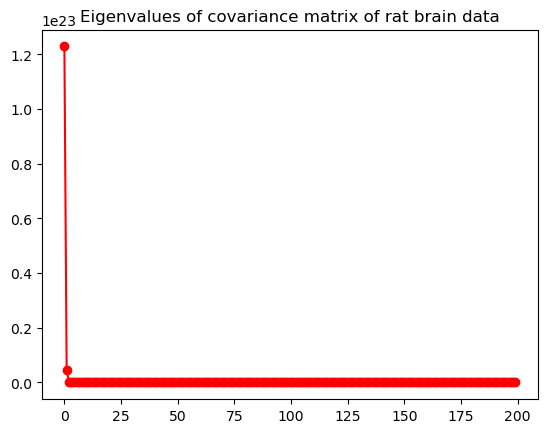

In [47]:
# Diagonalize the covariance matrix
eigvals_rat_brain, eigvecs_rat_brain = np.linalg.eig(cov_rat_brain)

# Sort eigenvalues and eigenvectors by decreasing eigenvalue
idx = eigvals_rat_brain.argsort()[::-1]
eigvals_rat_brain = eigvals_rat_brain[idx]
eigvecs_rat_brain = eigvecs_rat_brain[:,idx]

# Plot eigenvalues
plt.plot(eigvals_rat_brain[:], 'ro-')
plt.title("Eigenvalues of covariance matrix of rat brain data")
plt.show()

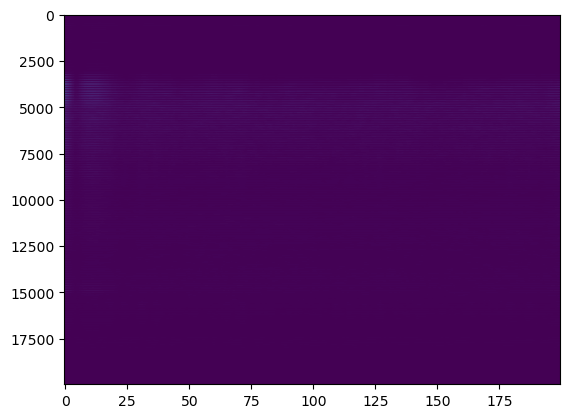

In [48]:
## Filter signal 
n = 10
I_f = np.diag([0 if i<n else 1 for i in  range(rat_brain.shape[2]) ])
rat_brain_casorati_filtered = rat_brain_casorati @ eigvecs_rat_brain @ I_f @ eigvecs_rat_brain.conj().T
plt.imshow(np.abs(rat_brain_casorati_filtered), aspect="auto")
rat_brain_filtered = casorati_matrix_inverse(rat_brain_casorati_filtered, rat_brain.shape[0], rat_brain.shape[1])

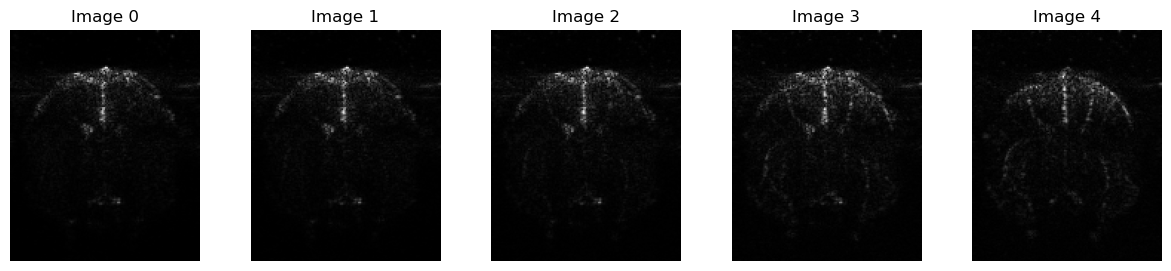

In [49]:
phase = False
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(np.abs(rat_brain_filtered[:,:,i]), cmap='gray')
    if phase :
        ax[i].imshow(np.angle(rat_brain_filtered[:,:,i*10]), alpha=0.3, cmap='hsv')
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()